In [1]:
import glob
import os
import numpy as np
import pandas as pd
import scipy.signal
import skimage
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

plt.style.use('styleNB.mplstyle')
   
ip = 200.0/303.0

/Users/nathanb/git/CRISPRi_screen_galvanotaxis/code/exploratory/../../../bebi103/viz.py:29: UserWarning: DataShader import failed with error "No module named 'datashader.bokeh_ext'".
Features requiring DataShader will not work and you will get exceptions.
  warnings.warn(f"""DataShader import failed with error "{e}".
/Users/nathanb/git/CRISPRi_screen_galvanotaxis/code/exploratory/../../../bebi103/viz.py:38: UserWarning: Could not import `stan` submodule. Perhaps pystan is not properly installed.
  warnings.warn('Could not import `stan` submodule. Perhaps pystan is not properly installed.')
/Users/nathanb/git/CRISPRi_screen_galvanotaxis/code/exploratory/../../../bebi103/__init__.py:19: UserWarning: Could not import `stan` submodule. Perhaps pystan is not properly installed.
  warnings.warn('Could not import `stan` submodule. Perhaps pystan is not properly installed.')


## Grab data

lets grab the files I'll be working with. In this experiment I look ~30 min videos (60 sec  intervals, 30 frames), 3 $\mu$m slides over 300 $\mu$m - using the water 20x objective. One channel is phase, while the other is the DNA (using Heocht stain at 1 $\mu$g/ml for 15 min). 

In [2]:
filelist = glob.glob(f_dir + 'processed_tracking/2024*/*.csv')
print(filelist)

['../../data/processed_tracking/20240403_trackmate_kalman_heonsu/20240403_dHL60_TMEM154KO-clone1_galvanin-GFP-HA_3um_60sec_1Vcm_1_tracks.csv', '../../data/processed_tracking/20240403_trackmate_kalman_heonsu/20240403_dHL60_TMEM154KO-clone1_galvanin-GFP-HA_3um_60sec_0Vcm_1_tracks.csv', '../../data/processed_tracking/20240403_trackmate_kalman_heonsu/20240403_dHL60_TMEM154KO-clone1_galvanin-GFP-HA_3um_60sec_3Vcm_1_tracks.csv', '../../data/processed_tracking/20240229_trackmate_kalman_tara/20240229_dHL60_KW_3um_60sec_3Vcm_1_tracks.csv', '../../data/processed_tracking/20240229_trackmate_kalman_tara/20240229_dHL60_TMEM154KO-clone1_3um_60sec_0Vcm_1_tracks.csv', '../../data/processed_tracking/20240229_trackmate_kalman_tara/20240229_dHL60_KW_3um_60sec_5Vcm_1_tracks.csv', '../../data/processed_tracking/20240229_trackmate_kalman_tara/20240229_dHL60_TMEM154KO-clone1_3um_60sec_3Vcm_1_tracks.csv', '../../data/processed_tracking/20240229_trackmate_kalman_tara/20240229_dHL60_KW_3um_60sec_0Vcm_1_tracks.c

In [3]:
df = pd.DataFrame()

for file in filelist:

    df_temp = pd.read_csv(file, skiprows=[0,2,3,4])
    df_temp = df_temp[['Track ID', 'Frame', 'X', 'Y', 'Z']]
    df_temp.columns = ['cell', 'frame', 'x', 'y', 'z']

    df_temp['celltype'] = ''.join(file.split('/')[-1].split('_3um_60sec')[0].split('_')[1:]) 
    df_temp['acqtime'] = '60sec'
    df_temp['E_V_cm'] = file.split('Vcm')[0].split('_')[-1]
    df_temp['date'] = file.split('/')[-1].split('_')[0]
    df_temp['material'] = 'collagen'
    df_temp['concentration'] = '0.75 mg/ml'
    df_temp['scope'] = 'Sydney'
    df_temp['magnification'] = '20xWater'
    df_temp['trial'] = file.split('cm_')[-1].split('_')[0]
    df_temp['media'] = 'L15 10%FBS'
    df_temp['analysis_date'] = '20240320'
    if 'tara' in file:
        df_temp['user'] = 'TE'
    elif 'heonsu' in file:
        df_temp['user'] = 'HK'
    else:
        df_temp['user'] = 'NB'
    

    df = pd.concat([df, df_temp], ignore_index = True)



In [4]:
df_groups = df.groupby(['celltype', 'E_V_cm', 'trial', 'date', 'user'])
for i, data in df_groups:
    print(i)

('dHL60KW', '0', '1', '20240211', 'NB')
('dHL60KW', '0', '1', '20240229', 'TE')
('dHL60KW', '0', '1', '20240327', 'TE')
('dHL60KW', '0', '1', '20240328', 'HK')
('dHL60KW', '1', '1', '20240314', 'TE')
('dHL60KW', '1', '1', '20240326', 'HK')
('dHL60KW', '1', '1', '20240327', 'TE')
('dHL60KW', '1', '1', '20240328', 'HK')
('dHL60KW', '1', '1', '20240328', 'TE')
('dHL60KW', '1', '2', '20240326', 'HK')
('dHL60KW', '3', '1', '20240211', 'NB')
('dHL60KW', '3', '1', '20240229', 'TE')
('dHL60KW', '3', '1', '20240314', 'TE')
('dHL60KW', '3', '1', '20240326', 'HK')
('dHL60KW', '5', '1', '20240211', 'NB')
('dHL60KW', '5', '1', '20240229', 'TE')
('dHL60KW', '5', '1', '20240328', 'HK')
('dHL60KW', '5', '1', '20240328', 'TE')
('dHL60TMEM154KO-clone1', '0', '1', '20240211', 'NB')
('dHL60TMEM154KO-clone1', '0', '1', '20240229', 'HK')
('dHL60TMEM154KO-clone1', '0', '1', '20240229', 'TE')
('dHL60TMEM154KO-clone1', '0', '1', '20240313', 'HK')
('dHL60TMEM154KO-clone1', '0', '1', '20240320', 'HK')
('dHL60TME

In [5]:
df = df[['cell', 'frame', 'x', 'y', 'z', 'celltype', 
      'E_V_cm', 'date', 'trial', 'user']]

In [6]:
df = df[~df.isin([np.nan, np.inf, -np.inf]).any(1)]

In [7]:
# remove cells that were not detected in every frame (I don't think this is actually needed)
df_temp = pd.DataFrame()
for sg, d in df.groupby(['celltype', 'E_V_cm', 'date', 'trial', 'cell']):
#     print(sg)
    if (len(d.frame.unique())-1) == (d.frame.max() - d.frame.min()):
        df_temp = df_temp.append(d, ignore_index = True)

/var/folders/hs/8f67z23n6g9g9g4y03yhrn_c0000gn/T/ipykernel_40263/4244195761.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(d, ignore_index = True)


In [8]:
df = df_temp.sort_values(['frame', 'cell'])

In [1]:
# # number of cells in data
# for sg, d in df.groupby(['celltype', 'E_V_cm', 'date', 'trial']):
#     print(sg)
#     print(len(d.frame.unique()))
    
#     count = 0
#     for g, d_ in d.groupby(['cell']):
#         count += 1
#     print(count)

## Visualize all tracks

In [10]:
# for sg, d in df.groupby(['celltype']):
#     print(sg)
    
#     count = 0
#     for g, d_ in d.groupby(['E_V_cm', 'date', 'trial', 'user']):
#         count += 1

#     f, ax = plt.subplots(count, 1, figsize=(6,count*6))    
#     ax = ax.ravel()


#     aq = 0
#     for g, d_ in d.groupby(['E_V_cm', 'date', 'trial', 'user']):
#         print(g)
            
#         ##################################
#         # plot tracks
#         ##################################
#         num_cells = len(d_.cell.unique())
#         for i in np.arange(0,num_cells):
#             data_ = d_[d_.cell==i]

#             data_ = data_.replace([np.inf, -np.inf], np.nan)
#             d_x = data_.x[~np.isnan(data_.x)] 
#             d_y = data_.y[~np.isnan(data_.y)] 
#             d_z = data_.z[~np.isnan(data_.z)] 
           
#             if len(d_x)==0:
#                 continue

#             x = data_.x.values 
#             y = data_.y.values 
#             z = data_.z.values 


#             ax[aq].plot(data_.x.values - 1024.0*ip, 
#                            1024.0*ip - data_.y.values)
#             ax[aq].set_xlabel('x position ($\mu$m)')
#             ax[aq].set_ylabel('y position ($\mu$m)')
# #             ax[aq].set_xlim(-676,0)
# #             ax[aq].set_ylim(0,676)
#             ax[aq].set_title(sg + '_' + str(g[0]) + 'E_V_cm_' + str(g[1]) +
#                              '_trial_' + str(g[2]) + '_user_' + str(g[-1]) )# + ', ' + g[0] + '\n' + 'date: ' + str(g[2]) + ', trial: ' + str(g[3]))


            
#         aq += 1
        
#     plt.tight_layout()

In [11]:
# notes on any samples that will be harder to perform drift correction (since I expect 
# a few based on some of the issues I encountered during imaging)
# my code below will work best for drift along horizontal axis, which is most common across my data. 

# Look more closely at :
# np.all([sg == 'dHL60TMEM154KO-clone1', g[0] == '5', g[1] == '20240229']):



dHL60TMEM154KO-clone1
('5', '20240229', '1', 'HK')


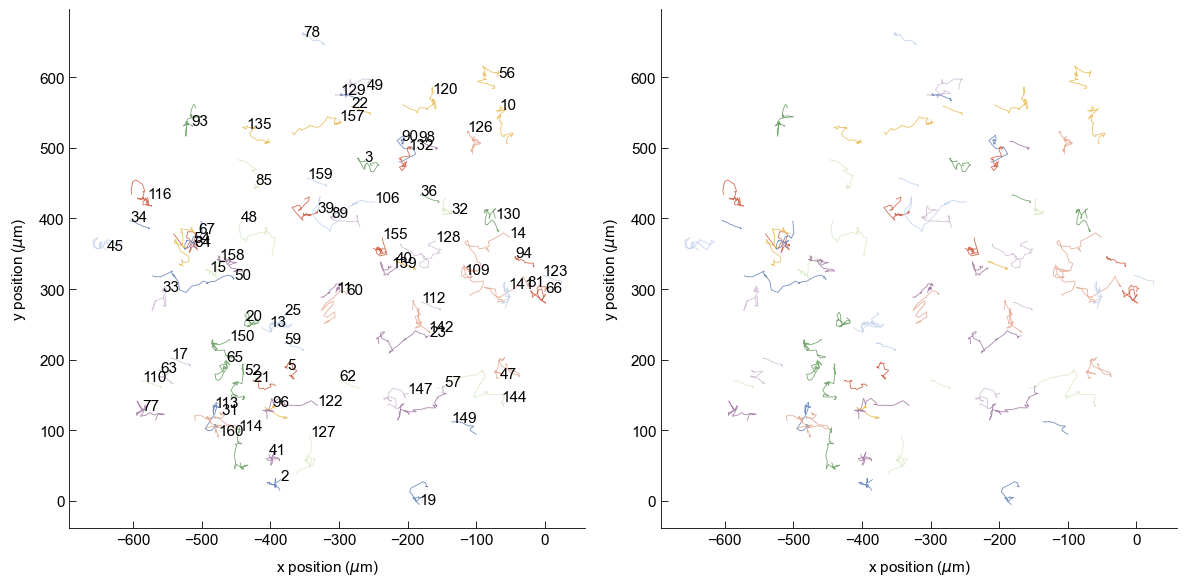

In [12]:
# I'm going to take a simple approach to identify the cells in
# np.all([sg == 'dHL60TMEM154KO-clone1', g[0] == '5', g[1] == '20240229']):

f, ax = plt.subplots(1, 2, figsize=(12,6))    
ax = ax.ravel()
    
for sg, d in df.groupby(['celltype']):
    if sg != 'dHL60TMEM154KO-clone1' :
        continue
    print(sg)
    
    aq = 0
    for g, d_ in d.groupby(['E_V_cm', 'date', 'trial', 'user']):
        if np.all([sg == 'dHL60TMEM154KO-clone1', g[0] == '5', g[1] == '20240229', g[-1] == 'HK']):
            print(g)
            
            ##################################
            # plot tracks
            ##################################
            num_cells = len(d_.cell.unique())
            for i in d_.cell.unique():
                data_ = d_[d_.cell==i]
                if len(data_.frame.unique()) == 31:
   
                    data_ = data_.replace([np.inf, -np.inf], np.nan)
                    d_x = data_.x[~np.isnan(data_.x)] 
                    d_y = data_.y[~np.isnan(data_.y)] 
                    d_z = data_.z[~np.isnan(data_.z)] 

                    if len(d_x)==0:
                        continue

                    x = data_.x.values 
                    y = data_.y.values 
                    z = data_.z.values 

                    for ax_ in ax:
                        ax_.plot(data_.x.values - 1024.0*ip, 
                                       1024.0*ip - data_.y.values)
                        ax_.set_xlabel('x position ($\mu$m)')
                        ax_.set_ylabel('y position ($\mu$m)')
                    
                    ax[0].annotate(i, xy=((data_.x.values - 1024.0*ip)[-1], 
                                                (1024.0*ip - data_.y.values)[-1]), 
                                        xytext=((data_.x.values - 1024.0*ip)[-1], 
                                                (1024.0*ip - data_.y.values)[-1]))




            
    plt.tight_layout()

dHL60TMEM154KO-clone1
('5', '20240229', '1', 'HK')


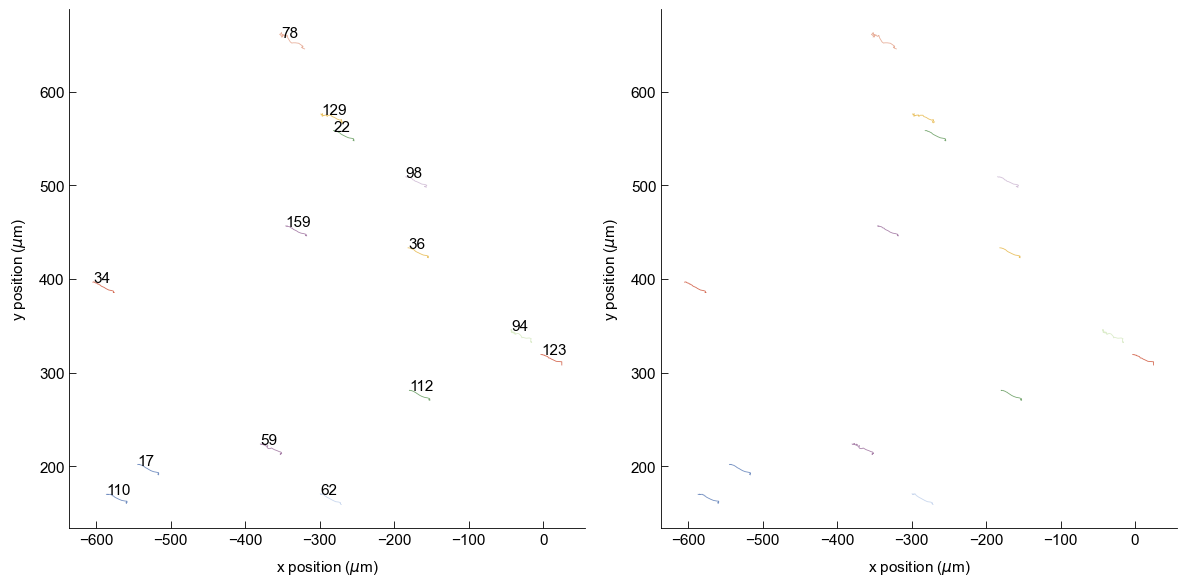

In [13]:
cell_arr =  [34, 22, 98, 159, 36, 62, 17, 110, 59, 94, 112, 129, 78, 123]


f, ax = plt.subplots(1, 2, figsize=(12,6))    
ax = ax.ravel()
    
for sg, d in df.groupby(['celltype']):
    if sg != 'dHL60TMEM154KO-clone1' :
        continue
    print(sg)
    
    aq = 0
    for g, d_ in d.groupby(['E_V_cm', 'date', 'trial', 'user']):
        if np.all([sg == 'dHL60TMEM154KO-clone1', g[0] == '5', g[1] == '20240229', g[-1] == 'HK']):
            print(g)
            
            ##################################
            # plot tracks
            ##################################
            num_cells = len(d_.cell.unique())
            for i in d_.cell.unique():
                data_ = d_[d_.cell==i]
                if i in cell_arr:
   
                    data_ = data_.replace([np.inf, -np.inf], np.nan)
                    d_x = data_.x[~np.isnan(data_.x)] 
                    d_y = data_.y[~np.isnan(data_.y)] 
                    d_z = data_.z[~np.isnan(data_.z)] 

                    if len(d_x)==0:
                        continue

                    x = data_.x.values 
                    y = data_.y.values 
                    z = data_.z.values 

                    for ax_ in ax:
                        ax_.plot(data_.x.values - 1024.0*ip, 
                                       1024.0*ip - data_.y.values)
                        ax_.set_xlabel('x position ($\mu$m)')
                        ax_.set_ylabel('y position ($\mu$m)')
                    
                    ax[0].annotate(i, xy=((data_.x.values - 1024.0*ip)[-1], 
                                                (1024.0*ip - data_.y.values)[-1]), 
                                        xytext=((data_.x.values - 1024.0*ip)[-1], 
                                                (1024.0*ip - data_.y.values)[-1]))




            
    plt.tight_layout()

In [14]:
#('1', '20240320', '1', 'TE')

dHL60TMEM154KO-clone1
('1', '20240320', '1', 'TE')


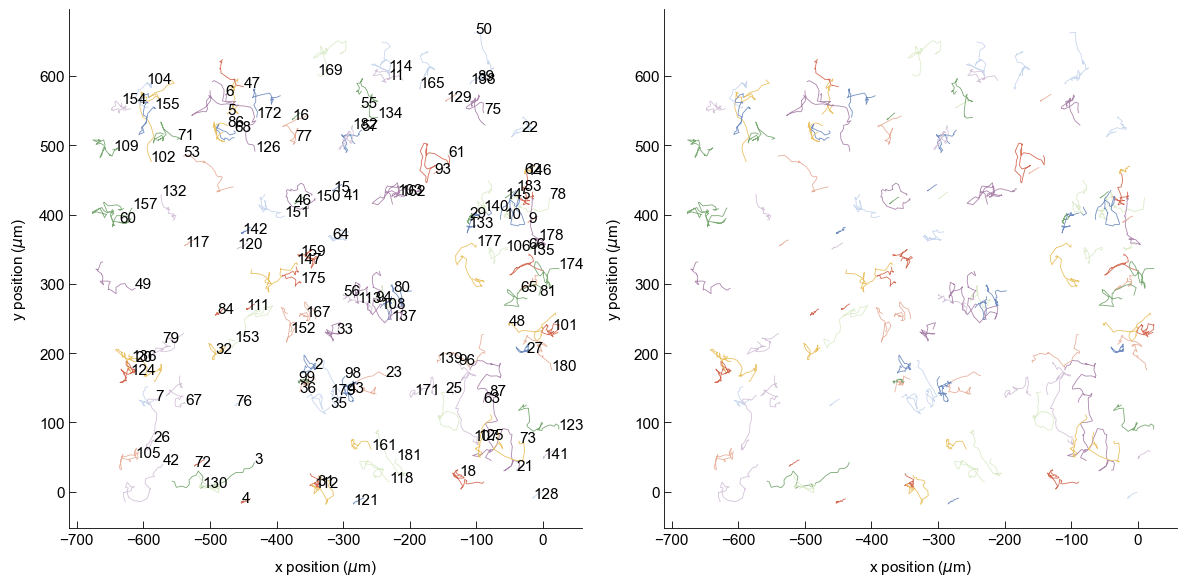

In [15]:

f, ax = plt.subplots(1, 2, figsize=(12,6))    
ax = ax.ravel()
    
for sg, d in df.groupby(['celltype']):
    if sg != 'dHL60TMEM154KO-clone1' :
        continue
    print(sg)
    
    aq = 0
    for g, d_ in d.groupby(['E_V_cm', 'date', 'trial', 'user']):
        if np.all([sg == 'dHL60TMEM154KO-clone1', g[0] == '1', g[1] == '20240320', g[-1] == 'TE']):
            print(g)
            
            ##################################
            # plot tracks
            ##################################
            num_cells = len(d_.cell.unique())
            for i in d_.cell.unique():
                data_ = d_[d_.cell==i]
                if len(data_.frame.unique()) == 31:
   
                    data_ = data_.replace([np.inf, -np.inf], np.nan)
                    d_x = data_.x[~np.isnan(data_.x)] 
                    d_y = data_.y[~np.isnan(data_.y)] 
                    d_z = data_.z[~np.isnan(data_.z)] 

                    if len(d_x)==0:
                        continue

                    x = data_.x.values 
                    y = data_.y.values 
                    z = data_.z.values 

                    for ax_ in ax:
                        ax_.plot(data_.x.values - 1024.0*ip, 
                                       1024.0*ip - data_.y.values)
                        ax_.set_xlabel('x position ($\mu$m)')
                        ax_.set_ylabel('y position ($\mu$m)')
                    
                    ax[0].annotate(i, xy=((data_.x.values - 1024.0*ip)[-1], 
                                                (1024.0*ip - data_.y.values)[-1]), 
                                        xytext=((data_.x.values - 1024.0*ip)[-1], 
                                                (1024.0*ip - data_.y.values)[-1]))




            
    plt.tight_layout()

dHL60TMEM154KO-clone1
('1', '20240320', '1', 'TE')


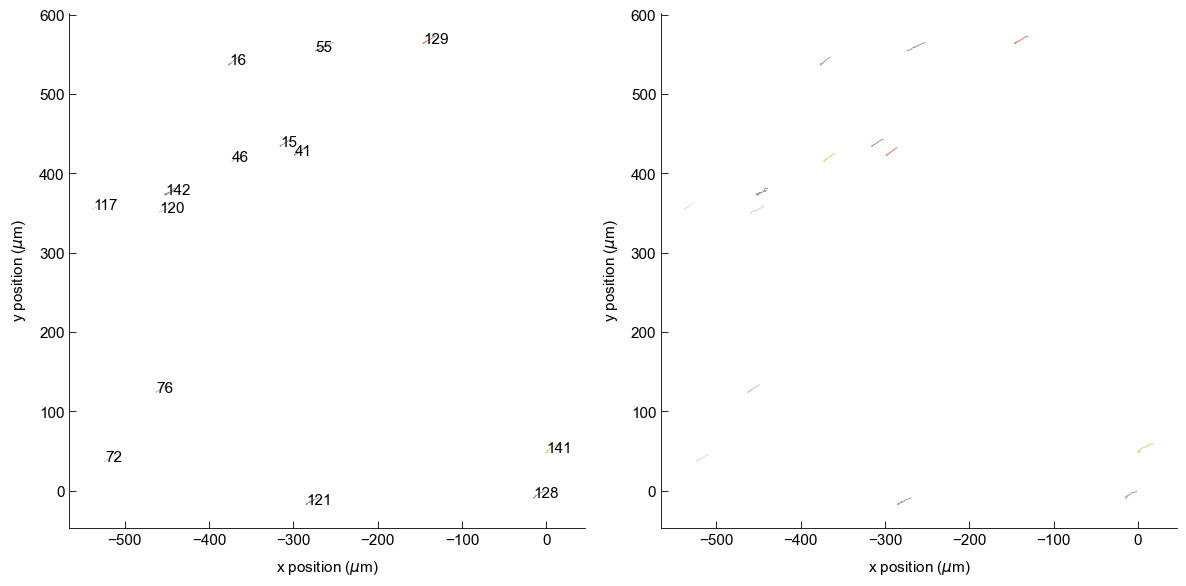

In [16]:
cell_arr =  [117, 142, 120, 72, 76, 46, 15, 41, 121, 16, 55, 129, 128, 141]


f, ax = plt.subplots(1, 2, figsize=(12,6))    
ax = ax.ravel()
    
for sg, d in df.groupby(['celltype']):
    if sg != 'dHL60TMEM154KO-clone1' :
        continue
    print(sg)
    
    aq = 0
    for g, d_ in d.groupby(['E_V_cm', 'date', 'trial', 'user']):
        if np.all([sg == 'dHL60TMEM154KO-clone1', g[0] == '1', g[1] == '20240320', g[-1] == 'TE']):
            print(g)
            
            ##################################
            # plot tracks
            ##################################
            num_cells = len(d_.cell.unique())
            for i in d_.cell.unique():
                data_ = d_[d_.cell==i]
                if i in cell_arr:
   
                    data_ = data_.replace([np.inf, -np.inf], np.nan)
                    d_x = data_.x[~np.isnan(data_.x)] 
                    d_y = data_.y[~np.isnan(data_.y)] 
                    d_z = data_.z[~np.isnan(data_.z)] 

                    if len(d_x)==0:
                        continue

                    x = data_.x.values 
                    y = data_.y.values 
                    z = data_.z.values 

                    for ax_ in ax:
                        ax_.plot(data_.x.values - 1024.0*ip, 
                                       1024.0*ip - data_.y.values)
                        ax_.set_xlabel('x position ($\mu$m)')
                        ax_.set_ylabel('y position ($\mu$m)')
                    
                    ax[0].annotate(i, xy=((data_.x.values - 1024.0*ip)[-1], 
                                                (1024.0*ip - data_.y.values)[-1]), 
                                        xytext=((data_.x.values - 1024.0*ip)[-1], 
                                                (1024.0*ip - data_.y.values)[-1]))




            
    plt.tight_layout()

dHL60KW
('0', '20240327', '1', 'TE')


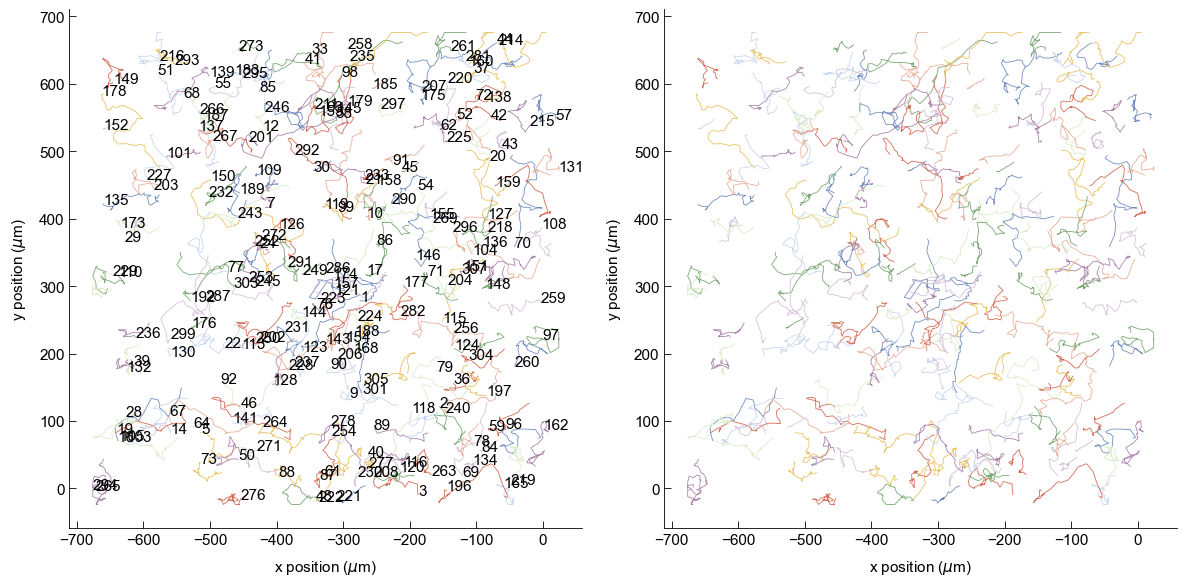

In [53]:

f, ax = plt.subplots(1, 2, figsize=(12,6))    
ax = ax.ravel()
    
for sg, d in df.groupby(['celltype']):
    if sg != 'dHL60KW' :
        continue
    print(sg)
    
    aq = 0
    for g, d_ in d.groupby(['E_V_cm', 'date', 'trial', 'user']):
        if np.all([sg == 'dHL60KW', g[0] == '0', g[1] == '20240327', g[-1] == 'TE']):
            print(g)
            
            ##################################
            # plot tracks
            ##################################
            num_cells = len(d_.cell.unique())
            for i in d_.cell.unique():
                data_ = d_[d_.cell==i]
                if len(data_.frame.unique()) == 31:
   
                    data_ = data_.replace([np.inf, -np.inf], np.nan)
                    d_x = data_.x[~np.isnan(data_.x)] 
                    d_y = data_.y[~np.isnan(data_.y)] 
                    d_z = data_.z[~np.isnan(data_.z)] 

                    if len(d_x)==0:
                        continue

                    x = data_.x.values 
                    y = data_.y.values 
                    z = data_.z.values 

                    for ax_ in ax:
                        ax_.plot(data_.x.values - 1024.0*ip, 
                                       1024.0*ip - data_.y.values)
                        ax_.set_xlabel('x position ($\mu$m)')
                        ax_.set_ylabel('y position ($\mu$m)')
                    
                    ax[0].annotate(i, xy=((data_.x.values - 1024.0*ip)[-1], 
                                                (1024.0*ip - data_.y.values)[-1]), 
                                        xytext=((data_.x.values - 1024.0*ip)[-1], 
                                                (1024.0*ip - data_.y.values)[-1]))




            
    plt.tight_layout()

In [2]:
# cell_arr =  [185, 45]

# f, ax = plt.subplots(1, 2, figsize=(12,6))    
# ax = ax.ravel()
    
# for sg, d in df.groupby(['celltype']):
#     if sg != 'dHL60KW' :
#         continue
#     print(sg)
    
#     aq = 0
#     for g, d_ in d.groupby(['E_V_cm', 'date', 'trial', 'user']):
#         if np.all([sg == 'dHL60KW', g[0] == '0', g[1] == '20240327', g[-1] == 'TE']):
#             print(g)
            
#             ##################################
#             # plot tracks
#            ##################################
#             num_cells = len(d_.cell.unique())
#             for i in d_.cell.unique():
#                 data_ = d_[d_.cell==i]
#                 if i in cell_arr:
   
#                     data_ = data_.replace([np.inf, -np.inf], np.nan)
#                     d_x = data_.x[~np.isnan(data_.x)] 
#                     d_y = data_.y[~np.isnan(data_.y)] 
#                     d_z = data_.z[~np.isnan(data_.z)] 

#                     if len(d_x)==0:
#                         continue

#                     x = data_.x.values 
#                     y = data_.y.values 
#                     z = data_.z.values 

#                     for ax_ in ax:
#                         ax_.plot(data_.x.values - 1024.0*ip, 
#                                        1024.0*ip - data_.y.values)
#                         ax_.set_xlabel('x position ($\mu$m)')
#                         ax_.set_ylabel('y position ($\mu$m)')
                    
#                     ax[0].annotate(i, xy=((data_.x.values - 1024.0*ip)[-1], 
#                                                 (1024.0*ip - data_.y.values)[-1]), 
#                                         xytext=((data_.x.values - 1024.0*ip)[-1], 
#                                                 (1024.0*ip - data_.y.values)[-1]))




            
#     plt.tight_layout()

In [17]:
# tot_len = 30
# df = df[df.frame != tot_len]

## Drift correction and identify motile cells


In [56]:
df_filtered = pd.DataFrame()
df_ignore_nonmotile = pd.DataFrame()
df_ignore_other = pd.DataFrame()

for sg, d in df.groupby(['celltype']):
    print(sg)

    aq = 0
    for g, d_ in d.groupby(['E_V_cm', 'date', 'trial', 'user']):
        print(g)
        tot_len = len(d_.frame.unique())

        ##################################
        # identify non-motile cells for drift correction
        ##################################
        nonmotile_cells = []
        if np.all([sg == 'dHL60TMEM154KO-clone1', g[0] == '5', g[1] == '20240229', g[-1] == 'HK']):
            print('yes')
            for x in [34, 22, 98, 159, 36, 62, 17, 110, 59, 94, 112, 129, 78, 123]:
                nonmotile_cells = np.append(nonmotile_cells, x)

        elif np.all([sg == 'dHL60TMEM154KO-clone1', g[0] == '1', g[1] == '20240320', g[-1] == 'TE']):
            print('yes')
            for x in [117, 142, 120, 72, 76, 46, 15, 41, 121, 16, 55, 129, 128, 141]:
                nonmotile_cells = np.append(nonmotile_cells, x) 
                
        elif np.all([sg == 'dHL60KW', g[0] == '0', g[1] == '20240327', g[-1] == 'TE']):
            print('yes')
            for x in [185, 45]:
                nonmotile_cells = np.append(nonmotile_cells, x) 
        else:
            
            for i in d_.cell.unique():
                data_ = d_[d_.cell==i]


                data_ = data_.replace([np.inf, -np.inf], np.nan)
                d_x = data_.x[~np.isnan(data_.x)] 
                d_y = data_.y[~np.isnan(data_.y)] 
                d_z = data_.z[~np.isnan(data_.z)] 

                if len(d_x) == tot_len:
                    if np.any([np.ptp(d_x)<=5.0, np.ptp(d_y)<=5.0]):
                        nonmotile_cells = np.append(nonmotile_cells, i)    

        s_x = [0]
        s_y = [0]
        s_z = [0]
        df_nonmotile = d_[d_.cell.isin(nonmotile_cells)]

        for t in np.arange(0,tot_len):
            if t == 0:
                continue
            shift_temp_x = []
            shift_temp_y = []
            shift_temp_z = []
            for cell, d_nm in df_nonmotile.groupby('cell'):
                shift_temp_x = np.append(shift_temp_x, d_nm[d_nm.frame==t].x.values - d_nm[d_nm.frame==t-1].x.values)
                shift_temp_y = np.append(shift_temp_y, d_nm[d_nm.frame==t].y.values - d_nm[d_nm.frame==t-1].y.values)
                shift_temp_z = np.append(shift_temp_z, d_nm[d_nm.frame==t].z.values - d_nm[d_nm.frame==t-1].z.values)
            
            s_x = np.append(s_x, np.mean(shift_temp_x))
            s_y = np.append(s_y, np.mean(shift_temp_y))
            s_z = np.append(s_z, np.mean(shift_temp_z))
        
        print(nonmotile_cells)
            
        ##################################
        # Apply drift correction, plot, and save motile cell track data
        ##################################

        for i in d_.cell.unique():
            data_ = d_[d_.cell==i]
            if len(data_.frame.unique()) != len(np.arange(data_.frame.min(), data_.frame.max()+1)):
                continue
                
            data_ = data_.replace([np.inf, -np.inf], np.nan)
            d_x = data_.x[~np.isnan(data_.x)] 
            d_y = data_.y[~np.isnan(data_.y)] 
            d_z = data_.z[~np.isnan(data_.z)] 
           
            if len(d_x)==0:
                continue

            if len(d_x) >=15:
                if len(df_nonmotile) == 0:
                    data_['x_shifted'] = data_['x']
                    data_['y_shifted'] = data_['y']
                    data_['z_shifted'] = data_['z']
                    d_s_x = data_.x_shifted
                    d_s_y = data_.y_shifted
                    d_s_z = data_.z_shifted
                else:
                    x = data_.x.values - np.cumsum(s_x[int(data_.frame.min()):int(data_.frame.max())+1])
                    y = data_.y.values - np.cumsum(s_y[int(data_.frame.min()):int(data_.frame.max())+1])
                    z = data_.z.values - np.cumsum(s_z[int(data_.frame.min()):int(data_.frame.max())+1])
                    data_['x_shifted'] = x
                    data_['y_shifted'] = y
                    data_['z_shifted'] = z
                    d_s_x = data_.x_shifted
                    d_s_y = data_.y_shifted
                    d_s_z = data_.z_shifted
   
                #########################
                # save to dataframe
                #########################            
                if i in nonmotile_cells:
                    df_ignore_nonmotile = pd.concat([df_ignore_nonmotile, data_], 
                                             ignore_index = True)
                    
                elif np.sqrt(np.ptp(d_s_x)**2 + np.ptp(d_s_y)**2 + np.ptp(d_s_z)**2) >=20:
                
#                 np.all([np.ptp(d_s_x)>=8, np.ptp(d_s_y)>=8, np.ptp(d_s_z)>=8]):                
                    df_filtered = pd.concat([df_filtered, data_], 
                                            ignore_index = True)
                    
                else:
                    df_ignore_other = pd.concat([df_ignore_other, data_], 
                                          ignore_index = True)
            
        aq += 1
        
#     plt.tight_layout()

dHL60KW
('0', '20240211', '1', 'NB')
[  8.  11.  35.  38.  45.  53.  61.  62.  63.  73.  75.  80.  84.  85.
  88.  99. 102. 118. 129. 134. 142. 144. 148. 154. 158. 160. 178. 180.
 188. 189. 190. 196. 208. 226. 238. 241. 242. 249. 251. 257.]
('0', '20240229', '1', 'TE')
[  3.   9.  14.  26.  30.  35.  37.  43.  58.  63.  93. 101. 105. 136.
 154. 165. 169. 174. 181. 183. 237. 251. 257. 265. 292. 295. 316. 317.
 319.]
('0', '20240327', '1', 'TE')
yes
[185.  45.]
('0', '20240328', '1', 'HK')
[ 24.  28.  37.  39.  64.  67.  79.  80.  85.  91.  94.  99. 105. 126.
 129. 132. 136. 138. 140. 147. 165. 168. 170. 173. 175. 179. 183. 204.]
('1', '20240314', '1', 'TE')
[ 15.  24.  36.  38.  49.  59.  70.  90.  92.  96. 117. 123. 127. 147.
 164. 171. 179. 185. 186. 191. 192. 193. 205. 209. 217. 222. 227. 230.
 234. 236. 241. 262. 265.]
('1', '20240326', '1', 'HK')
[  6.  10.  15.  24.  26.  29.  32.  35.  39.  49.  59.  73.  74.  80.
  81.  82.  83.  92.  94.  98. 108. 112. 116. 127. 132. 139. 140. 

('3', '20240320', '1', 'TE')
[  2.   7.   8.  24.  32.  40.  45.  52.  53.  68.  69.  72.  77.  85.
  87.  91.  97. 107. 108. 111. 128. 140. 146. 152.]
('5', '20240229', '1', 'HK')
yes
[ 34.  22.  98. 159.  36.  62.  17. 110.  59.  94. 112. 129.  78. 123.]
('5', '20240229', '1', 'TE')
[  4.   6.  15.  38.  53.  55.  69.  77.  82.  84.  85.  86. 108. 118.
 124. 129. 140. 145. 156. 157. 167. 169. 176. 189. 196. 197. 203. 218.
 231. 234. 237. 255. 262. 265. 286. 300. 312. 314. 330. 331. 335. 345.
 353. 372. 374. 375. 377. 386.]
('5', '20240328', '1', 'TE')
[ 51. 105. 111. 119. 150. 159. 163. 165. 166. 207. 213. 225. 236.]
dHL60TMEM154KO-clone12
('0', '20240212', '1', 'NB')
[ 25.  39.  48.  83.  91.  96. 126. 130. 147. 152. 153. 165. 170. 179.
 186. 216. 258. 280. 286. 293. 298. 301. 305. 306. 334. 338. 344. 349.]
('3', '20240212', '1', 'NB')
[  4.  24.  29.  36.  55.  63.  71.  72.  82.  89.  90. 111. 112. 118.
 132. 139. 143. 145. 150. 151. 164. 175. 179. 191. 196. 201. 216. 226.
 236. 2

('3', '20240307', '2', 'HK')
[  2.   3.   4.   5.   8.  10.  11.  20.  21.  27.  29.  30.  32.  33.
  35.  36.  40.  41.  45.  46.  47.  50.  51.  53.  54.  55.  56.  60.
  62.  63.  65.  68.  73.  74.  75.  76.  77.  78.  79.  80.  81.  87.
  91.  92.  95.  97. 100. 106. 108. 109. 111. 112. 113. 116. 117. 119.
 122. 127. 128. 129. 132. 133. 134. 135. 136. 137. 139. 145. 146. 149.
 150. 152. 163. 165. 168. 169. 170. 171. 174. 176. 179. 180. 181. 184.
 185. 186. 188. 191. 192. 193. 194. 195. 196. 197. 198. 199. 205. 207.
 208. 209. 210. 214. 217. 219. 225. 227. 228. 230. 231. 232. 233. 235.
 238. 240. 243. 244. 246. 248. 251. 253. 254. 255. 256. 258. 259. 262.
 263. 266. 267. 270. 271. 272. 273. 276. 277. 280. 282. 283. 284. 286.
 287. 291. 293. 294. 297. 299. 300. 306.]
('3', '20240313', '1', 'HK')
[  3.  11.  23.  37.  43.  44.  50.  55.  62.  64.  74.  75.  78.  89.
 104. 106. 108. 110. 113. 124. 127. 130. 132. 137. 138. 147. 153. 156.
 164. 167. 168. 171. 172. 177. 179. 188. 190. 19

/Users/nathanb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nathanb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/nathanb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nathanb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/nathanb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nathanb/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: inva

[]
('5', '20240328', '1', 'HK')
[  2.  11.  13.  15.  17.  22.  27.  28.  39.  55.  59.  66.  68.  72.
  77.  79.  80.  90.  97.  98. 109. 113. 114. 126. 143. 145. 161. 167.
 169. 170. 179. 181. 189. 191. 194. 196. 199. 201. 207. 210. 222. 231.
 234. 236. 238. 241. 248.]


dHL60KW
dHL60TMEM154KO-clone1
dHL60TMEM154KO-clone12
dHL60TMEM154KO-clone1galvanin-GFP-HA


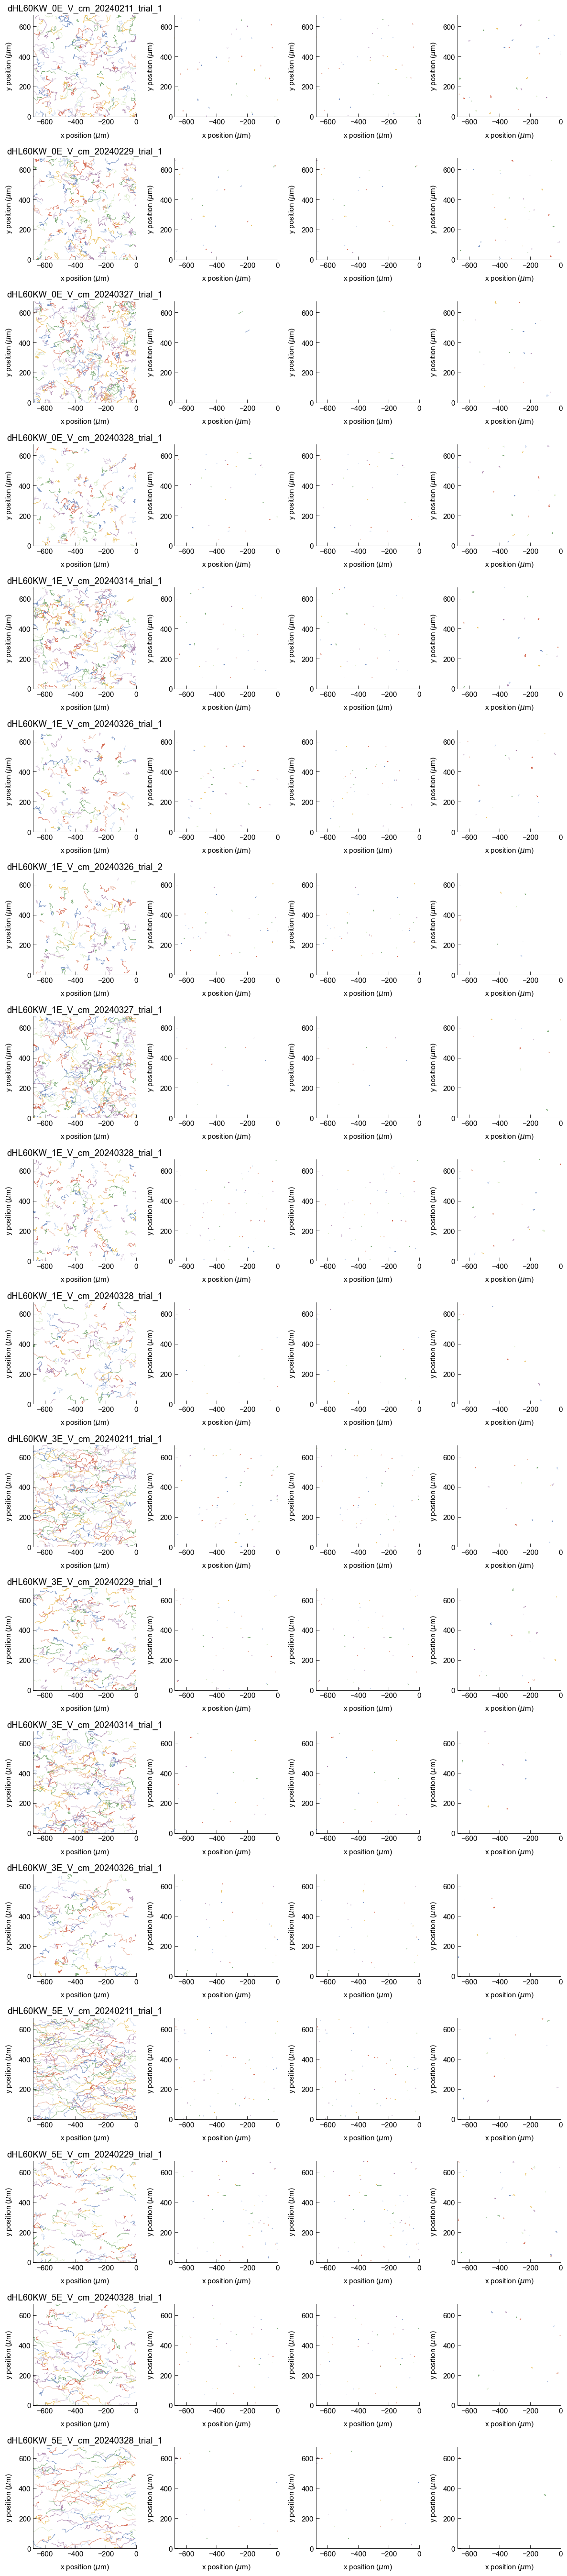

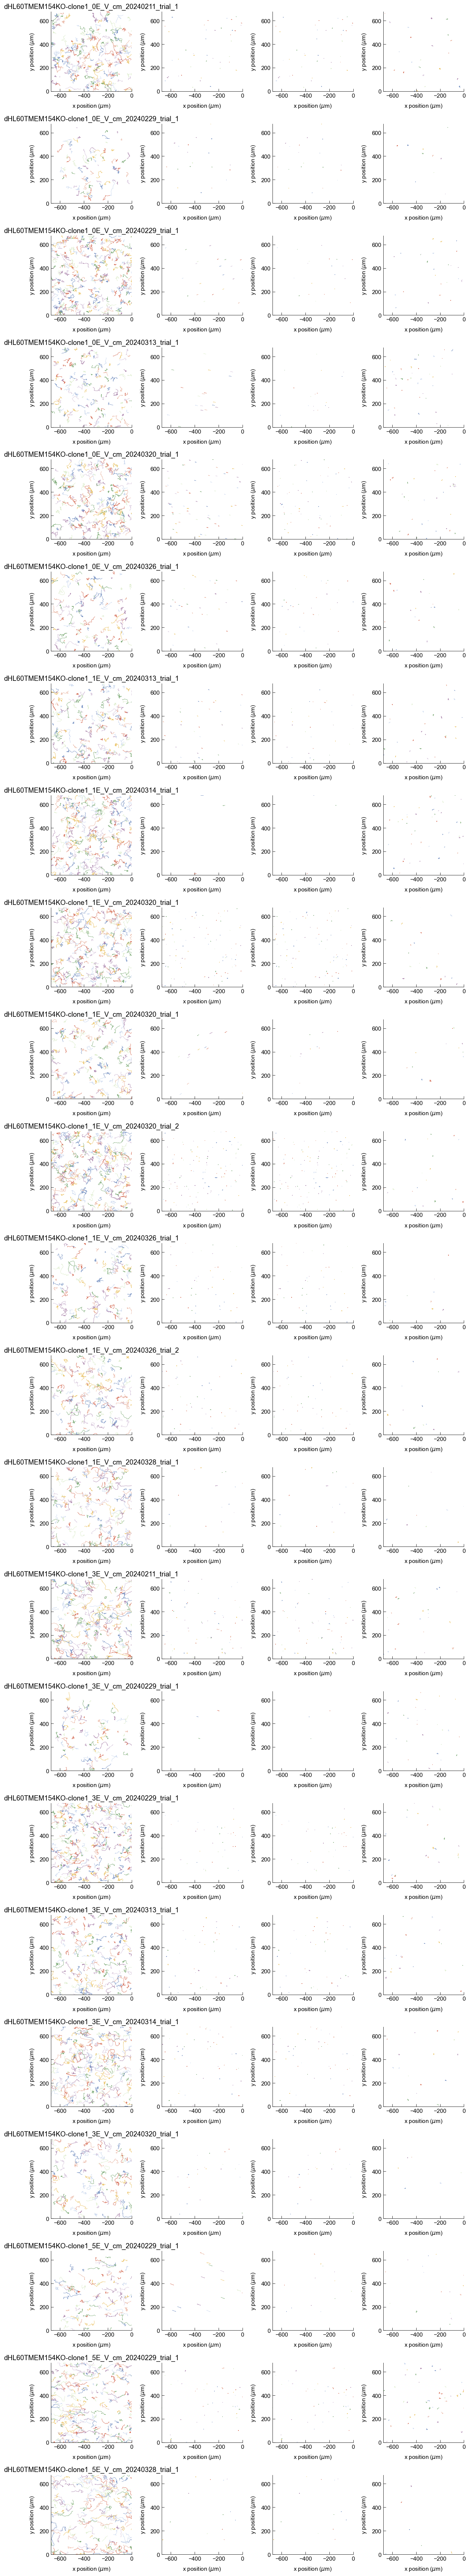

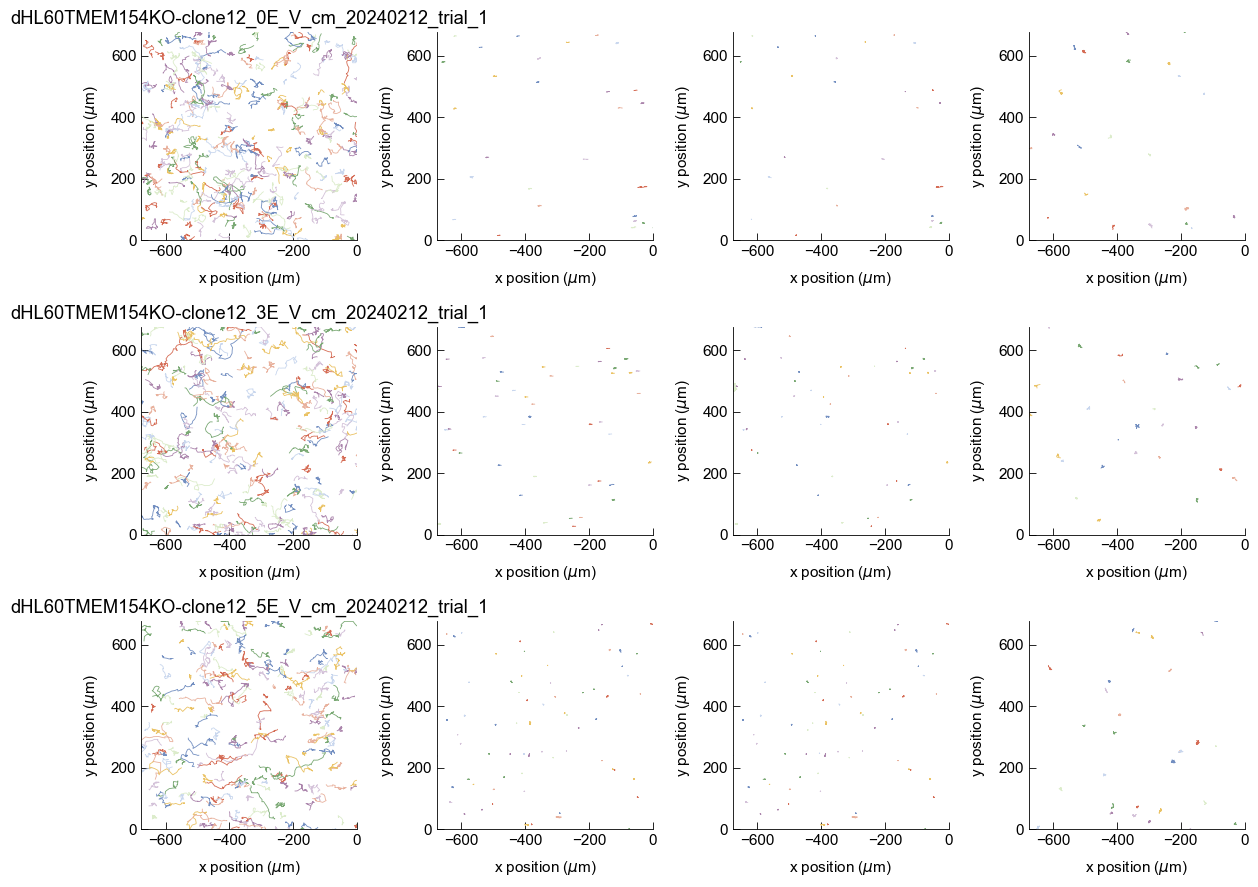

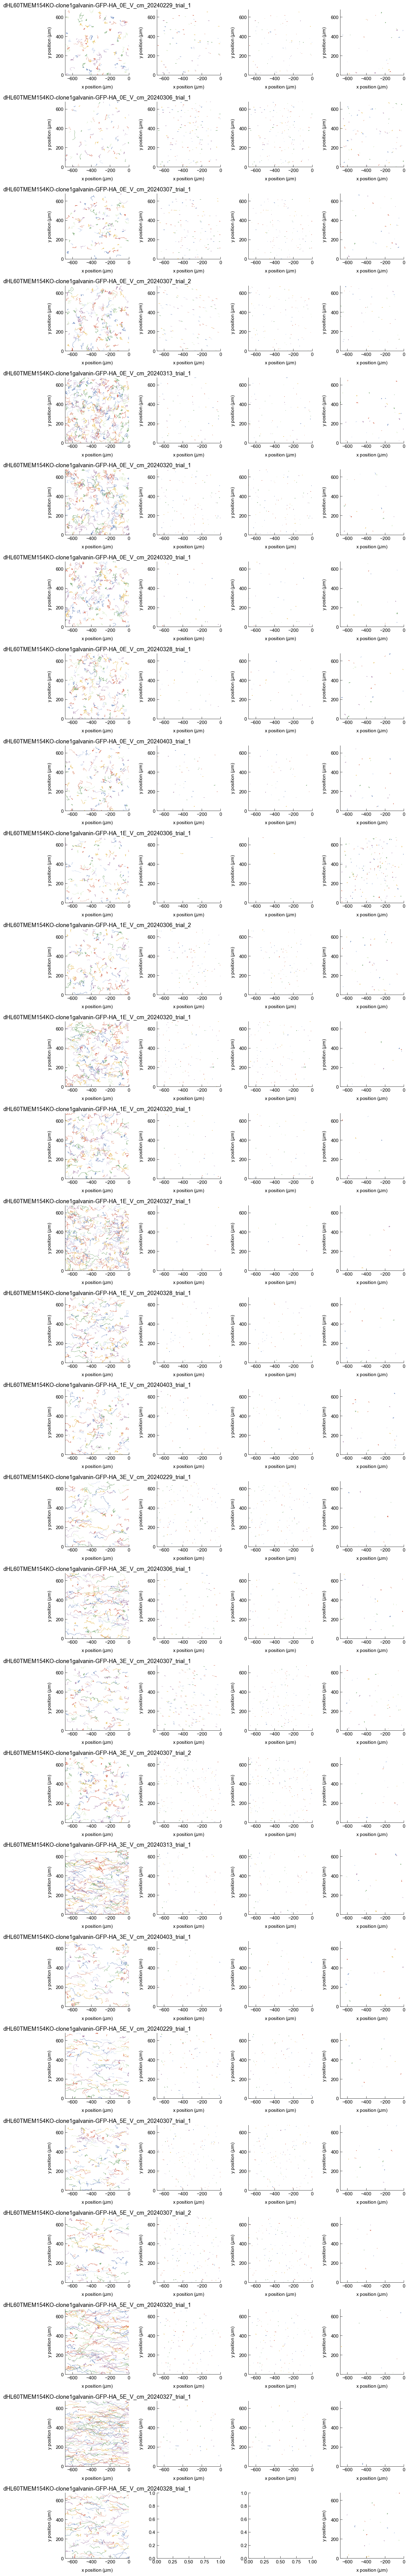

In [57]:
for sg, d in df_filtered.groupby(['celltype']):
#     print(sg)
    
    count = 0
    for g, d_ in d.groupby(['E_V_cm', 'date', 'trial', 'user']):
        count += 1

    f, ax = plt.subplots(count, 4, figsize=(12,count*3))    

    aq = 0
    for g, d_ in d.groupby(['E_V_cm', 'date', 'trial', 'user']):
            
        ##################################
        # plot tracks
        ##################################
#         num_cells = len(d_.cell.unique())
        for i in d_.cell.unique():
            data_ = d_[d_.cell==i]

            data_ = data_.replace([np.inf, -np.inf], np.nan)
            d_x = data_.x[~np.isnan(data_.x)] 
           
            if len(d_x)==0:
                continue

            ax[aq, 0].plot(data_.x_shifted.values - 1024.0*ip, 
                           1024.0*ip - data_.y_shifted.values)
            ax[aq, 0].set_xlabel('x position ($\mu$m)')
            ax[aq, 0].set_ylabel('y position ($\mu$m)')
            ax[aq, 0].set_xlim(-676,0)
            ax[aq, 0].set_ylim(0,676)
            ax[aq, 0].set_title(sg + '_' + str(g[0]) + 'E_V_cm_' + str(g[1]) +
                             '_trial_' + str(g[2]))
            
        aq += 1

    ##################################
    # non motile cells - uncorrected
    ##################################    
    d = df_ignore_nonmotile[df_ignore_nonmotile.celltype == sg]
    print(sg)
    aq = 0
    for g, d_ in d.groupby(['E_V_cm', 'date', 'trial', 'user']):
            
        ##################################
        # plot tracks
        ##################################
#         num_cells = len(d_.cell.unique())
#         print(num_cells)
#         if sg == 'sgFH':
#             print(d_.x.values)
        for i in d_.cell.unique():
            data_ = d_[d_.cell==i]

            data_ = data_.replace([np.inf, -np.inf], np.nan)
            d_x = data_.x[~np.isnan(data_.x)] 
           
            if len(d_x)==0:
                continue

            ax[aq, 1].plot(data_.x.values - 1024.0*ip, 
                           1024.0*ip - data_.y.values)
            ax[aq, 1].set_xlabel('x position ($\mu$m)')
            ax[aq, 1].set_ylabel('y position ($\mu$m)')
            ax[aq, 1].set_xlim(-676,0)
            ax[aq, 1].set_ylim(0,676)
            
        aq += 1
        
    ##################################
    # non motile cells - corrected
    ##################################        
    d = df_ignore_nonmotile[df_ignore_nonmotile.celltype == sg]
    aq = 0
    for g, d_ in d.groupby(['E_V_cm', 'date', 'trial', 'user']):
            
        ##################################
        # plot tracks
        ##################################
#         num_cells = len(d_.cell.unique())
        for i in d_.cell.unique():
            data_ = d_[d_.cell==i]

            data_ = data_.replace([np.inf, -np.inf], np.nan)
            d_x = data_.x[~np.isnan(data_.x)] 
           
            if len(d_x)==0:
                continue

            ax[aq, 2].plot(data_.x_shifted.values - 1024.0*ip, 
                           1024.0*ip - data_.y_shifted.values)
            ax[aq, 2].set_xlabel('x position ($\mu$m)')
            ax[aq, 2].set_ylabel('y position ($\mu$m)')
            ax[aq, 2].set_xlim(-676,0)
            ax[aq, 2].set_ylim(0,676)
            
        aq += 1
 
    d = df_ignore_other[df_ignore_other.celltype == sg]
    aq = 0
    for g, d_ in d.groupby(['E_V_cm', 'date', 'trial', 'user']):
            
        ##################################
        # plot tracks
        ##################################
#         num_cells = len(d_.cell.unique())
        for i in d_.cell.unique():
            data_ = d_[d_.cell==i]

            data_ = data_.replace([np.inf, -np.inf], np.nan)
            d_x = data_.x[~np.isnan(data_.x)] 

           
            if len(d_x)==0:
                continue

            ax[aq, 3].plot(data_.x_shifted.values - 1024.0*ip, 
                           1024.0*ip - data_.y_shifted.values)
            ax[aq, 3].set_xlabel('x position ($\mu$m)')
            ax[aq, 3].set_ylabel('y position ($\mu$m)')
            ax[aq, 3].set_xlim(-676,0)
            ax[aq, 3].set_ylim(0,676)
          
            
        aq += 1
            
        
        
    plt.tight_layout()

In [58]:
df_filtered['x'] = df_filtered['x_shifted'] 
df_filtered['y'] = df_filtered['y_shifted'] 
df_filtered['z'] = df_filtered['z_shifted'] 

In [59]:
df_filtered.head()

cell  frame           x          y           z celltype E_V_cm      date  \
0     1      0  224.688313  60.967256  300.000000  dHL60KW      0  20240211   
1     1      1  234.142473  61.729068  299.161784  dHL60KW      0  20240211   
2     1      2  241.205035  57.075039  298.060585  dHL60KW      0  20240211   
3     1      3  240.578251  56.429442  298.609065  dHL60KW      0  20240211   
4     1      4  245.309731  50.526570  298.065615  dHL60KW      0  20240211   

  trial user   x_shifted  y_shifted   z_shifted  
0     1   NB  224.688313  60.967256  300.000000  
1     1   NB  234.142473  61.729068  299.161784  
2     1   NB  241.205035  57.075039  298.060585  
3     1   NB  240.578251  56.429442  298.609065  
4     1   NB  245.309731  50.526570  298.065615

## Plot trajectories and save to file

In [60]:
for g, d in df_filtered.groupby(['celltype', 'E_V_cm', 'trial', 'date', 'user']):

    num_cells = len(d.cell.unique())
#     print(g, num_cells)
    ###################################################
    ########### figure of absolute trajectories #######
    ###################################################
    
    f = plt.figure(figsize=(6,6))

    gs = gridspec.GridSpec(2, 2,height_ratios=[1,(1024.0*ip)/300], width_ratios=[(1024.0*ip)/300,1])

    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[2])
    ax3 = plt.subplot(gs[3])

    for c, d_  in d.groupby('cell'):

        if len(d_) <= 15:
            continue

        ax1.plot(d_.x - 1024.0*ip, 
                       d_.z)
        ax1.set_ylim(0,300)
        ax1.set_xlim(-676,0)
        ax2.plot(d_.x - 1024.0*ip, 
                       1024.0*ip - d_.y)
        ax2.set_xlabel('x position ($\mu$m)')
        ax2.set_ylabel('y position ($\mu$m)')
        ax2.set_xlim(-676,0)
        ax2.set_ylim(0,676)

        ax3.plot(d_.z, 
                 1024.0*ip - d_.y)

        ax1.xaxis.set_visible(False)
        ax1.set_ylabel('z ($\mu$m)')
        ax3.yaxis.set_visible(False)
        ax3.set_xlabel('z ($\mu$m)')
        ax3.set_xlim(0,300)
        ax3.set_ylim(0,676)

    plt.tight_layout()
    plt.savefig(f_dir + 'tracking_plots/' + 
            str(g[-2]) + '_' +
            g[0] + '_'  +
            str(g[1]) + 'Vcm_' + 
            str(g[2]) + '_user_' + str(g[-1]) + '_abs_trajectories.pdf')


    plt.close()

    ###################################################
    ########## figure of relative trajectories ########
    ###################################################
    f = plt.figure(figsize=(6,6))

    gs = gridspec.GridSpec(2, 2)

    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[2])
    ax3 = plt.subplot(gs[3])

    for c, d_  in d.groupby('cell'):

        if len(d_) <= 15:
            continue
            
        t0_x = d_[d_.frame == d_.frame.min()].x.values
        t0_y = d_[d_.frame == d_.frame.min()].y.values
        t0_z = d_[d_.frame == d_.frame.min()].z.values

        if np.shape(t0_x)== (0,):
            continue
        if len(d_.x.values) != len(d_.y.values):
            continue

        ax1.plot(d_.x - t0_x, 
                       d_.z - t0_z, color = 'k', alpha = 0.2, lw = 1)

        ax2.plot(d_.x - t0_x, 
                       d_.y - t0_y, color = 'k', alpha = 0.2, lw = 1)
        ax2.set_xlabel('x position ($\mu$m)')
        ax2.set_ylabel('y position ($\mu$m)')

        ax3.plot(d_.z - t0_z, 
                 d_.y - t0_y, color = 'k', alpha = 0.2, lw = 1)

        ax1.xaxis.set_visible(False)
        ax1.set_ylabel('z ($\mu$m)')
        ax3.yaxis.set_visible(False)
        ax3.set_xlabel('z ($\mu$m)')

    for ax_ in [ax1,ax2,ax3]:
        ax_.spines['left'].set_position(('data', 0))
        ax_.spines['bottom'].set_position(('data', 0))
        ax_.xaxis.set_label_coords(0.6, -0.05)
        ax_.yaxis.set_label_coords(0.0, 0.6)

        ax_.set_xlim(-150,150)
        ax_.set_ylim(-150,150)
        ax_.set_axisbelow(True)

    plt.tight_layout()
    plt.savefig(f_dir + 'tracking_plots/' + 
            str(g[-2]) + '_' +
            g[0] + '_'  +
            str(g[1]) + 'Vcm_' + 
            str(g[2]) + '_user_' + str(g[-1]) + '_rel_trajectories.pdf')

    
    plt.close()



In [61]:
for g, d in df_filtered.groupby(['celltype', 'E_V_cm']):

    ###################################################
    ########## figure of relative trajectories ########
    ###################################################
    f = plt.figure(figsize=(6,6))

    gs = gridspec.GridSpec(2, 2)

    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[2])
    ax3 = plt.subplot(gs[3])

    for i, d_ in d.groupby(['cell',  'trial', 'date', 'user']):

        if len(d_) <= 15:
            continue

        t0_x = d_[d_.frame == d_.frame.min()].x.values
        t0_y = d_[d_.frame == d_.frame.min()].y.values
        t0_z = d_[d_.frame == d_.frame.min()].z.values

        if np.shape(t0_x)== (0,):
            continue
        if len(d_.x.values) != len(d_.y.values):
            continue

        ax1.plot(d_.x - t0_x, 
                       d_.z - t0_z, color = 'k', alpha = 0.2, lw = 1, zorder = 20)

        ax2.plot(d_.x - t0_x, 
                       d_.y - t0_y, color = 'k', alpha = 0.2, lw = 1, zorder = 20)
        ax2.set_xlabel('x position ($\mu$m)')
        ax2.set_ylabel('y position ($\mu$m)')

        ax3.plot(d_.z - t0_z, 
                 d_.y - t0_y, color = 'k', alpha = 0.2, lw = 1, zorder = 20)

        ax1.xaxis.set_visible(False)
        ax1.set_ylabel('z ($\mu$m)')
        ax3.yaxis.set_visible(False)
        ax3.set_xlabel('z ($\mu$m)')

        
    for ax_ in [ax1,ax2,ax3]:
        ax_.spines['left'].set_position(('data', 0))
        ax_.spines['bottom'].set_position(('data', 0))
        ax_.xaxis.set_label_coords(0.6, -0.05)
        ax_.yaxis.set_label_coords(0.0, 0.6)

        ax_.set_xlim(-250,250)
        ax_.set_ylim(-250,250)
        ax_.set_axisbelow(True)


    plt.tight_layout()
    plt.savefig(f_dir + 'tracking_plots/' + 
            str(g[0]) + '_' + 
            str(g[1]) + 'Vcm_rel_trajectories.pdf')

    plt.close()





In [63]:

df_filtered.to_csv('../../data/processed_tracking/20240424_compiled_galvaninKOlines_tracking.csv')